# Librerías y Selección de Dispositivo

In [1]:
import numpy as np
from numba import cuda

print(cuda.gpus)
print(cuda.detect())
cuda.select_device(0)

<Managed Device 0>
Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-8ef58ccd-5377-5ebf-816c-fc98cb83a9f8
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
True


<weakproxy at 0x7e4455beaa20 to Device at 0x7e4455bc3220>

# Ejercicio de Procesamiento de Imagenes

1.0 255.0 [[ 18.  17.  17. ... 126. 126. 123.]
 [ 21.  21.  22. ... 128. 127. 124.]
 [ 25.  26.  27. ... 130. 129. 125.]
 ...
 [ 67.  56.  51. ...  68.  65.  63.]
 [ 67.  61.  55. ...  76.  73.  69.]
 [ 69.  65.  64. ...  75.  80.  78.]]


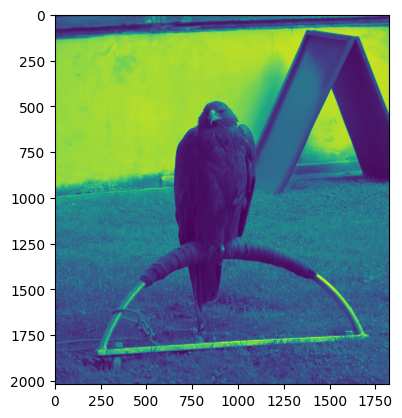

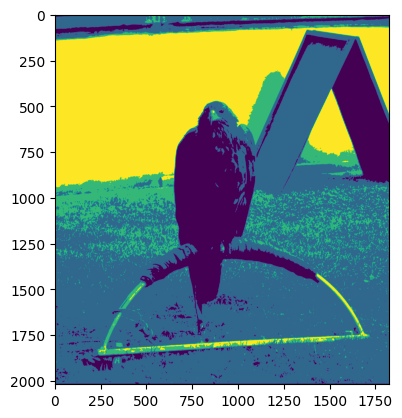

In [2]:
from numba import cuda
import matplotlib.pyplot as plt
from skimage import data, io
import math
import numpy as np

@cuda.jit
def rgb(pixels, output, size):
    row, col = cuda.grid(2)
    if (row + 2) < size[0] and (col + 2) < size[1] and row > 2 and col > 2:
      divisor = 75
      sum = pixels[row-2][col-1]/divisor + pixels[row-2][col]/divisor + pixels[row-2][col+1]/divisor + \
            pixels[row-1][col-1]/divisor + pixels[row-1][col]/divisor + pixels[row-1][col+1]/divisor + \
            pixels[row-0][col-1]/divisor + pixels[row-0][col]/divisor + pixels[row-0][col+1]/divisor + \
            pixels[row+1][col-1]/divisor + pixels[row+1][col]/divisor + pixels[row+1][col+1]/divisor + \
            pixels[row+2][col-1]/divisor + pixels[row+2][col]/divisor + pixels[row+2][col+1]/divisor
      output[row][col] = round(sum/15)


#eagle = data.eagle().astype(np.float32)
eagle = io.imread("eagle.png").astype(np.float32)
print(eagle.min(), eagle.max(), eagle)
plt.imshow(eagle)
plt.show()

##(2019, 1826)
host_pixels = eagle
device_pixels = cuda.to_device(host_pixels)
device_output = cuda.device_array(host_pixels.shape)


threads_per_block = (16, 16)
blocks_per_grid_x = int(math.ceil(eagle.shape[0] / threads_per_block[0]))
blocks_per_grid_y = int(math.ceil(eagle.shape[1] / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

rgb[blocks_per_grid, threads_per_block](device_pixels,
                                        device_output,
                                        eagle.shape)

host_roja = device_output.copy_to_host()
plt.imshow(host_roja)
plt.show()
